# Exercise 1: Accessing Neo4j DB from Python

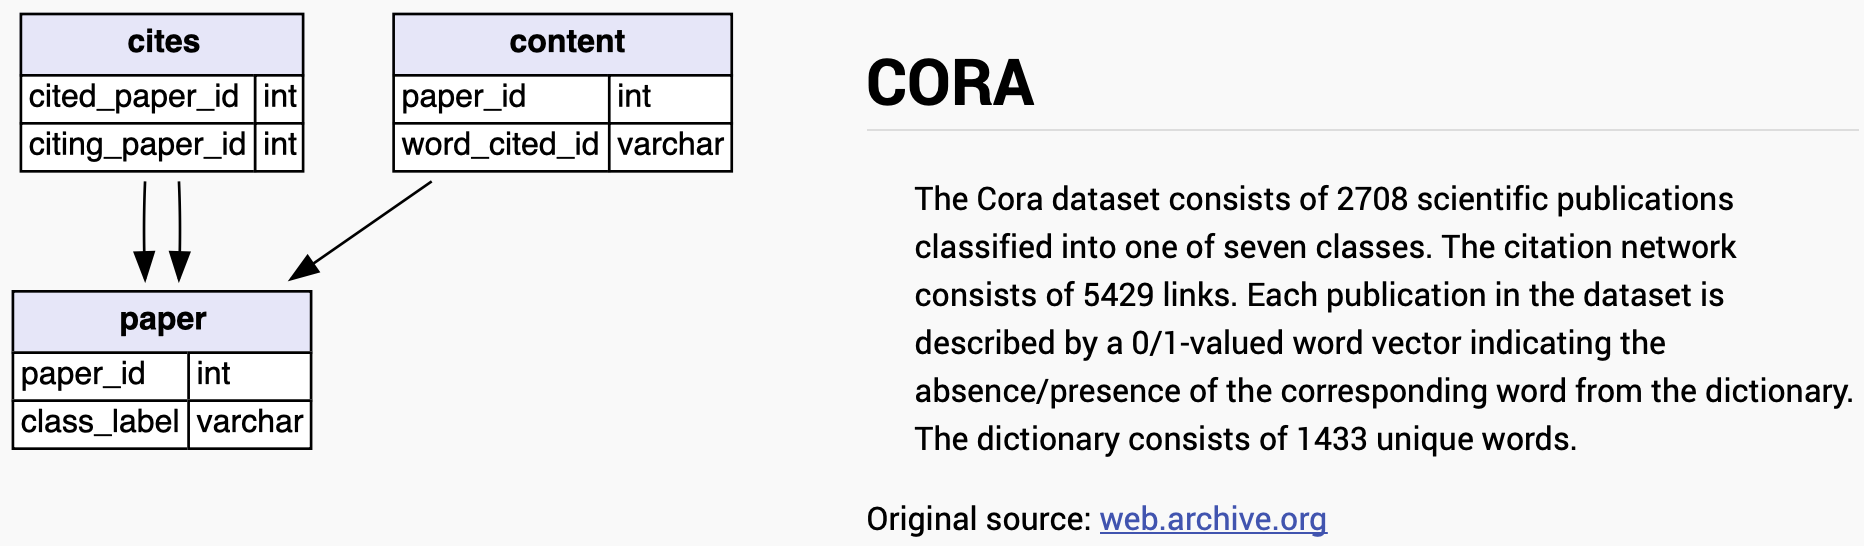

In [1]:
# Install Neo4j driver for Python
!pip install neo4j

In [2]:
from neo4j import GraphDatabase

## Create Database

### Build Connection to Neo4j

In [3]:
# Create a connection class
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)      
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
    def close(self):
        if self.__driver is not None:
            self.__driver.close()  

In [29]:
# Connect to Neo4j
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="cora")

In [30]:
# Send query: create DB if not exists
conn.query("CREATE OR REPLACE DATABASE cora")

[]

### Create Model
Create a citation graph from the public Cora CSV files. 
- read the CSV file containing (nodes) information _line by line_
- add each line as a node to the graph with a label __Paper__ and properties __id__ and __class__

#### Get the Source Data

In [31]:
# First, explore the data in pandas 
import pandas as pd
url = 'https://raw.githubusercontent.com/ngshya/datasets/master/cora/cora_content.csv'
papers = pd.read_csv(url, delimiter = ',')
papers.head()

,paper_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1425,feature_1426,feature_1427,feature_1428,feature_1429,feature_1430,feature_1431,feature_1432,feature_1433,label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [32]:
# Write the data in Neo4j - create nodes, no features
query_string = '''
    USING PERIODIC COMMIT 500
    LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/ngshya/datasets/master/cora/cora_content.csv" 
    AS line FIELDTERMINATOR ','
    CREATE (:Paper {id: line.paper_id, class: line.label})
    '''

In [33]:
# Execute the request
conn.query(query_string, db='cora')

[]

In [34]:
# Read the citation data and explore it
import pandas as pd
url = 'https://raw.githubusercontent.com/ngshya/datasets/master/cora/cora_cites.csv'
cites = pd.read_csv(url, delimiter = ',')
cites.head()

,cited_paper_id,citing_paper_id
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [37]:
# Create the edges while reading the sites file
query_string = '''
    USING PERIODIC COMMIT 500
    LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/ngshya/datasets/master/cora/cora_cites.csv'
    AS line FIELDTERMINATOR ','
    MATCH (citing_paper:Paper {id: line.citing_paper_id}),(cited_paper:Paper {id: line.cited_paper_id})
    CREATE (citing_paper)-[:CITES]->(cited_paper)
    '''

In [38]:
conn.query(query_string, db='cora')

[]

## Search the DB

In [39]:
# categories of papers
query_string = '''
    MATCH (p:Paper)
    RETURN DISTINCT p.class
    ORDER BY p.class
    '''

In [40]:
conn.query(query_string, db='cora')

[<Record p.class='Case_Based'>,
 <Record p.class='Genetic_Algorithms'>,
 <Record p.class='Neural_Networks'>,
 <Record p.class='Probabilistic_Methods'>,
 <Record p.class='Reinforcement_Learning'>,
 <Record p.class='Rule_Learning'>,
 <Record p.class='Theory'>]

In [41]:
# most cited paper
query_string = '''
    MATCH ()-->(p:Paper) 
    RETURN id(p), count(*) as citdegree 
    ORDER BY citdegree DESC LIMIT 10
    '''

In [42]:
conn.query(query_string, db='cora')

[<Record id(p)=163 citdegree=332>,
 <Record id(p)=565 citdegree=152>,
 <Record id(p)=747 citdegree=148>,
 <Record id(p)=427 citdegree=122>,
 <Record id(p)=552 citdegree=84>,
 <Record id(p)=611 citdegree=82>,
 <Record id(p)=74 citdegree=76>,
 <Record id(p)=294 citdegree=64>,
 <Record id(p)=430 citdegree=64>,
 <Record id(p)=638 citdegree=64>]

## GDS Algorithms

In [43]:
# Create a graph object where Paper are the nodes and CITES are the relations
query_string = '''
    CALL gds.graph.create('coraGraph', 'Paper','CITES')
'''

In [44]:
# Remember to reconnect after restarting Neo4j
conn.query(query_string, db='cora')

[<Record nodeProjection={'Paper': {'label': 'Paper', 'properties': {}}} relationshipProjection={'CITES': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'CITES', 'properties': {}}} graphName='coraGraph' nodeCount=2708 relationshipCount=10858 createMillis=79>]

In [45]:
# Create node property pagerank
query_string = '''
    CALL gds.pageRank.write('coraGraph', {writeProperty: 'pagerank'})
    YIELD nodePropertiesWritten, ranIterations
'''

In [46]:
conn.query(query_string, db='cora')

[<Record nodePropertiesWritten=2708 ranIterations=20>]

In [47]:
# Create node property betweenness
query_string = '''
    CALL gds.betweenness.write('coraGraph', {writeProperty: 'betweenness'})
    YIELD minimumScore, maximumScore, scoreSum, nodePropertiesWritten
'''

In [48]:
conn.query(query_string, db='cora')

[<Record minimumScore=0.0 maximumScore=9523.5 scoreSum=179657.00000000003 nodePropertiesWritten=2708>]

## Back to Dataframe

In [49]:
query_string = '''
    MATCH (p:Paper)
    RETURN DISTINCT p.id, p.class, p.pagerank, p.betweenness
'''

In [50]:
dtf = pd.DataFrame([dict(_) for _ in conn.query(query_string, db='cora')])
dtf10 = dtf.sample(10)

In [51]:
dtf10.sort_values(by=['p.pagerank','p.betweenness'], inplace=True, ascending=False)
dtf10

,p.id,p.class,p.pagerank,p.betweenness
2342,3232,Theory,0.463407,0.0
581,1953,Case_Based,0.430787,0.0
382,44017,Theory,0.427313,6.0
573,74700,Probabilistic_Methods,0.334682,1.5
441,284414,Case_Based,0.192500,39.0
1834,248431,Genetic_Algorithms,0.192500,0.0
440,181782,Reinforcement_Learning,0.150000,0.0
1073,1105932,Rule_Learning,0.150000,0.0
1448,1117833,Case_Based,0.150000,0.0
1575,1136814,Genetic_Algorithms,0.150000,0.0


## Reference
- https://towardsdatascience.com/neo4j-cypher-python-7a919a372be7<br>
- https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4<br>
- Cora DB: https://relational.fit.cvut.cz/dataset/CORA